In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
import ObsModels
import fun

from FSC import GenerationContinuousObs as FSC_ContinuousObs
from FSC import InferenceContinuousObs as FSC_InferenceContinuousObs

import numba as nb

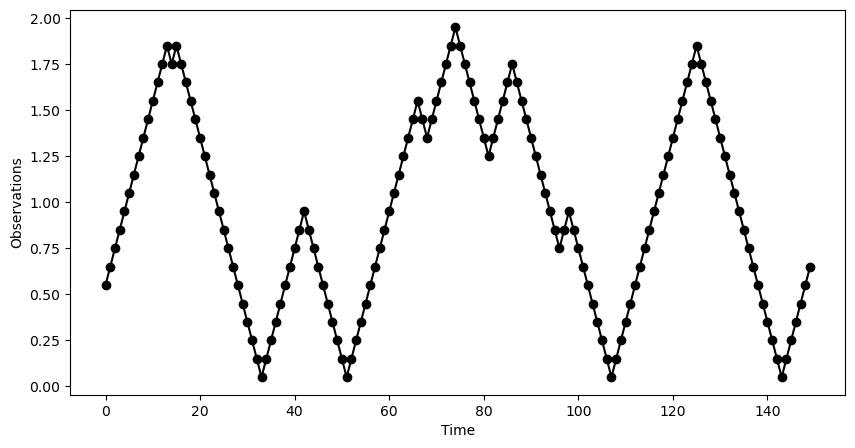

In [4]:
NSteps = 150
NTraj = 200

rate = 0.1
mplus = 0.1
mminus = -0.1
dt = 1
y0 = 1

observations = ObsModels.LinearRamps(NTraj, NSteps, rate, mplus, mminus, dt, initial_seed = 0)

features = []

for i in range(NTraj):
    features.append(np.array([np.ones(NSteps), observations[i]]))


fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

## Structured transition matrix

In [5]:
M = 2
A = 2

F = features[0].shape[0]

ThetaFollowSwitch = np.array([[[[10, 0.01], [0.01, 0.01]],
                               [[0.01, 0.01], [0.01, 10]]],
                              [[[0.01, 0.01], [0.01, 10]],
                               [[10, 0.01], [0.01, 0.01]]]])


Psi = np.array([1, 2])

FSC = FSC_ContinuousObs(ThetaFollowSwitch, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 features.


In [6]:
FSC.load_features(features)

In [7]:
trajectories = FSC.generate_trajectories(NSteps = NSteps)
Time = np.arange(NSteps)

In [53]:
trajectories[0]

{'actions': array([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 'memories': array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 0

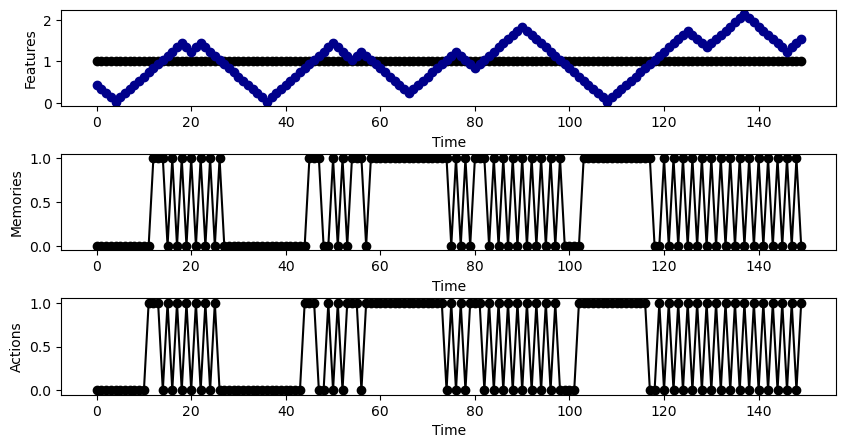

In [21]:
colors = ["k", "darkblue"]
idx_trj = 2
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time, colors_features = colors)

In [9]:
nLL = 0

for trj in trajectories:
    nLL += FSC.evaluate_nloglikelihood(trj)

nLL/len(trajectories)

/Users/giorgionicoletti/Library/CloudStorage/OneDrive/ICTP/projects/InferenceFSCs/notebooks/../modules/FSC.py:1348: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  m = transition_probs @ rho


15.749951608671301

### Inference

In [12]:
FSC_tofit = FSC_InferenceContinuousObs(M, A, F, seed = 123)
FSC_tofit.load_trajectories(trajectories)

nLL = 0

for idx_traj in range(len(trajectories)):
    nLL += FSC_tofit.evaluate_nloglikelihood(idx_traj = idx_traj)

nLL/len(trajectories)

tensor(139.9668, device='mps:0', grad_fn=<DivBackward0>)

In [13]:
%%time
tloss, vloss = FSC_tofit.optimize(NEpochs = 40, NBatch = 20, lr = 0.05, gamma = 0.99)

Training with 160 trajectories and validating with 40 trajectories.
Epoch 1 - Training loss: 113.53126602172851, Validation loss: 106.98953170776367 - Learning rate: 0.05
Epoch 2 - Training loss: 99.47860717773438, Validation loss: 84.6285924911499 - Learning rate: 0.0495
Epoch 3 - Training loss: 69.96527862548828, Validation loss: 54.936711525917055 - Learning rate: 0.049005
Epoch 4 - Training loss: 52.16442337036133, Validation loss: 48.27752403020859 - Learning rate: 0.04851495
Epoch 5 - Training loss: 46.27495422363281, Validation loss: 43.19523491859436 - Learning rate: 0.0480298005
Epoch 6 - Training loss: 41.245814132690434, Validation loss: 38.94985927343369 - Learning rate: 0.047549502495
Epoch 7 - Training loss: 37.62237968444824, Validation loss: 35.67761347293854 - Learning rate: 0.04707400747005
Epoch 8 - Training loss: 35.06196479797363, Validation loss: 33.31543850898743 - Learning rate: 0.0466032673953495
Epoch 9 - Training loss: 32.84447135925293, Validation loss: 31.4

In [42]:
def fun_to_fit(x, a):
    return 1/(x*(1 + 15.7/a*x))

In [52]:
vals = -np.diff(vloss)/vloss[:-1]

import scipy.optimize as opt

opt.curve_fit(fun_to_fit, np.arange(1, len(vals)), vals[1:], p0 = [10])

(array([9.83378081]), array([[0.91357866]]))

/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_61222/1166851926.py:2: RuntimeWarning: divide by zero encountered in divide
  return 1/(x*(1 + 15.7/a*x))


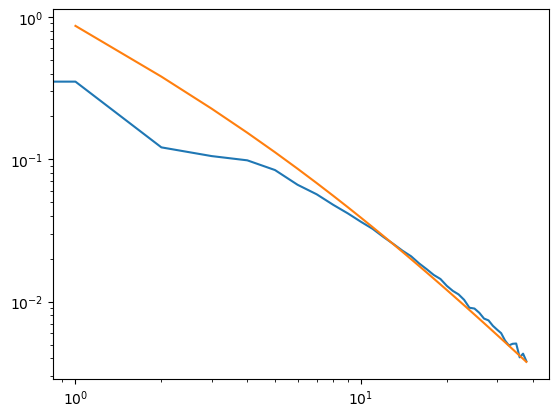

In [50]:
plt.plot(np.arange(39), -np.diff(vloss)/vloss[:-1])
# plt.plot(np.arange(39), np.arange(39).astype(np.float32)**-2)
# plt.plot(np.arange(39), np.arange(39).astype(np.float32)**-1)

plt.plot(np.arange(39), fun_to_fit(np.arange(39), 100))
plt.yscale('log')
plt.xscale('log')

### Comparison

In [14]:
FSC_inferred = FSC_ContinuousObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                                 FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 features.


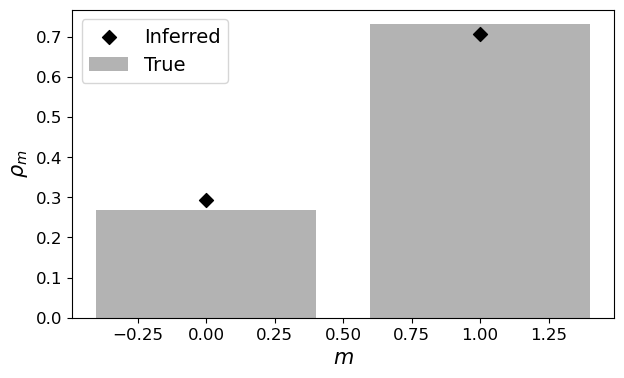

In [15]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC.rho, color = "dimgray", alpha = 0.5, label = "True")
ax.scatter(np.arange(M), FSC_inferred.rho, color = "black", marker = "D", s = 50, label = "Inferred")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14)

plt.show()

[1.         1.85037446]


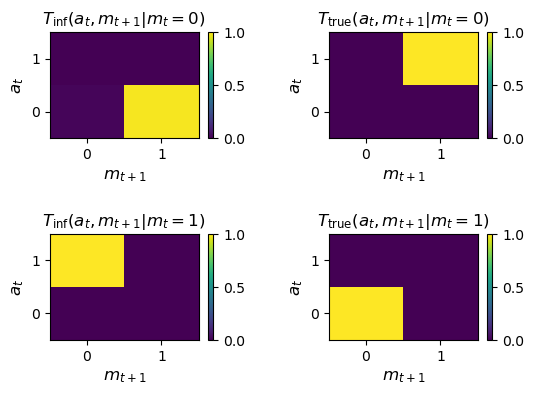

[1.         0.25264546]


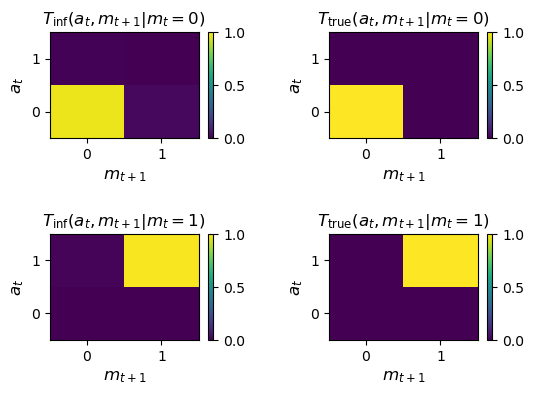

[1.         0.56270498]


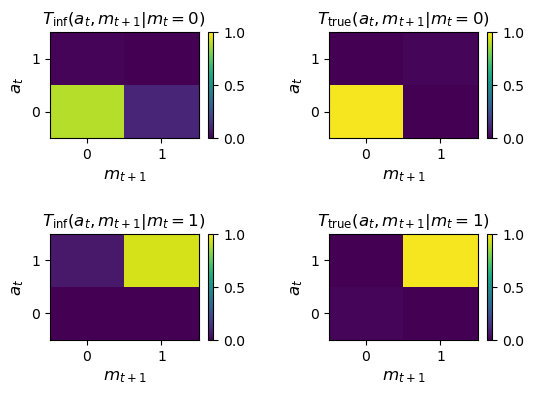

[1.         0.33226722]


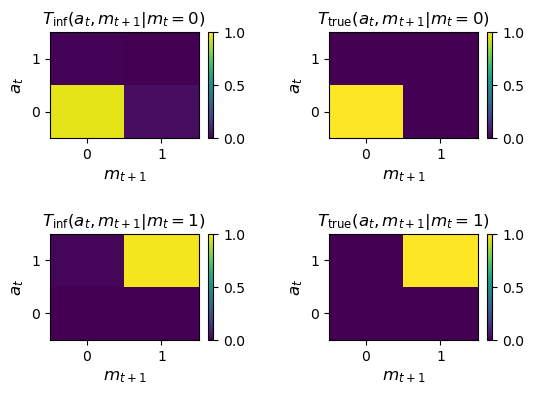

[1.         2.50283098]


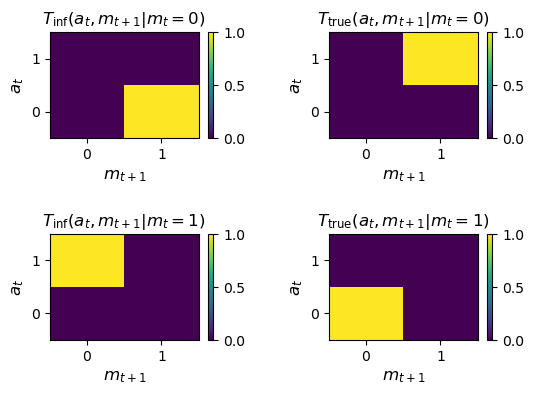

In [16]:
Nfeat_toplot = 5

np.random.seed(0)
idxs_f = np.random.choice(len(features), Nfeat_toplot, replace = False)
t = 20
for idx_f in idxs_f:
    fig, axs = plt.subplots(M, 2, figsize=(6,4))
    plt.subplots_adjust(hspace = 0.9, wspace=0.5)
    for a in axs.flatten():
        a.set_xticks(FSC.MemSpace)
        a.set_yticks(FSC.ActSpace)
        a.set_xlabel("$m_{t+1}$", fontsize = 12)
        a.set_ylabel("$a_t$", fontsize = 12)

    c = 0

    feature_test = features[idx_f][:, t]
    print(feature_test)

    TMat_true = FSC.get_TMat(feature_test)
    TMat_inf = FSC_inferred.get_TMat(feature_test)

    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, TMat_inf[idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, TMat_true[idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

    plt.show()

In [17]:
FSC_inferred.load_features(features)

In [18]:
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)

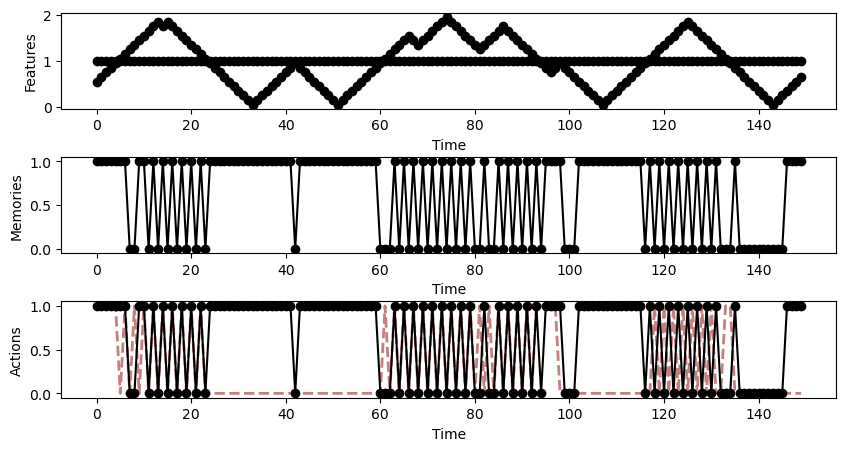

In [19]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

ax[2].plot(trajectories[idx_trj]["actions"], label = "True", color = "darkred", zorder = -1, alpha = 0.5, lw = 2, ls = "--")

In [159]:
A = 3
F = 2
M = 4

np.random.seed(0)

Theta = np.random.rand(F, M, M, A)
Psi = np.random.rand(M)

In [160]:
FSC = FSC_ContinuousObs(Theta, Psi)
FSC.load_features(features)

In [161]:
trajectories = FSC.generate_trajectories(NSteps = NSteps)
Time = np.arange(NSteps)

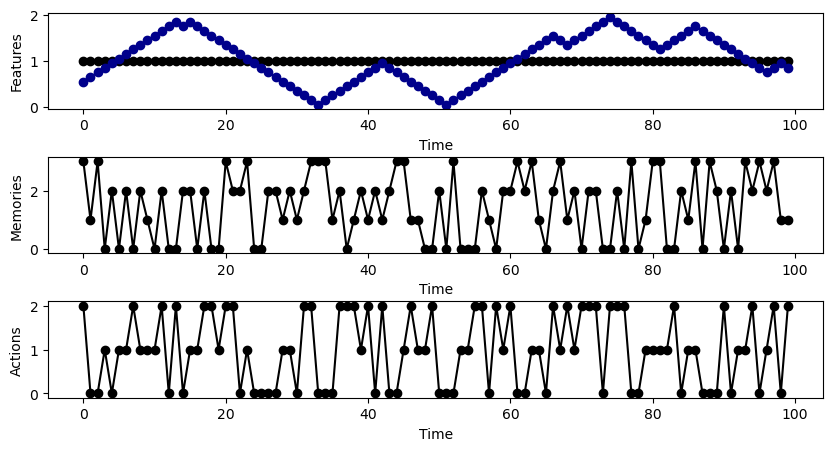

In [162]:
colors = ["k", "darkblue"]
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time, colors_features = colors)

In [163]:
nLL = 0

for trj in trajectories:
    nLL += FSC.evaluate_nloglikelihood(trj)

nLL/len(trajectories)

109.3709531557735